# Setup

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

import matplotlib as mpl
import matplotlib.cm as cm
import statsmodels.api as sm
from scipy.stats import linregress

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

import pathlib

from scipy.optimize import curve_fit

import pymannkendall as mk

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import glob
from scipy.optimize import curve_fit
init_notebook_mode(connected=True)

## Pick Paths and Folders

In [2]:
main_path = pathlib.Path("G:/Shared drives/UGS_Groundwater/Projects/Pahvant_Valley")
spr_data = main_path / "Python" / "DailyValues2022163816.csv"
climate_dir = main_path / "Climate_Station_Data"
pumpdata = main_path / "Groundwater_Pumping" / "Groundwater_Conditions_In_Utah.xlsx"
figure_dir = main_path / "Writing" / "Figures" 

## Define Custom Functions

In [3]:
def plotmk(series,axis,units='ac-ft/yr',color=None):
    seas = mk.yue_wang_modification_test(series)
    mklist = [seas.trend, seas.h, seas.p, seas.z, seas.Tau, seas.s, seas.slope, seas.intercept]
    if mklist[1]:
        frst = series.first_valid_index()
        lst = series.last_valid_index()
        x = range(frst,lst)
        lab = f"MK {mklist[-2]:.0f} {units}"
        if color:
            clr = color
        else:            
            if mklist[0] == 'increasing':
                clr = 'red'
            else:
                clr = 'green'
        axis.plot(x,[(i-1985)*mklist[-2]+mklist[-1]+5000 for i in x],linestyle=":",label=lab,color=clr)

# Spring Data

https://www.waterrights.utah.gov/cgi-bin/dvrtview.exe?Modinfo=StationView&STATION_ID=4610&RECORD_YEAR=2022

Bring in data from the Water Rights website.

In [4]:
clear_lake_hist = pd.read_csv(spr_data,skiprows=4,index_col='Date',parse_dates=True)
clear_lake_hist = clear_lake_hist[clear_lake_hist['Flow']>0]
clear_lake_hist['wateryear'] = clear_lake_hist.index.shift(-9,freq='ME').year+1
clear_lake_hist = clear_lake_hist.reset_index().drop_duplicates(subset='Date', keep='first').set_index('Date')

The water Rights data has points that the USGS data does not, but both datasetsets have outliers in the 1960s that likely represent freezing events that were not filtered out.  We remove these values with a rolling mean filter.

In [5]:
df = clear_lake_hist

# Calculate rolling mean
window_size = 12  # You can adjust the window size
df['RollingMean'] = df['Flow'].rolling(window=window_size).mean()

# Define a threshold for filtering
threshold = 10.0  # Values exceeding the rolling mean by more than 2 units

# Filter outliers
df['IsOutlier'] = (df['Flow'] > (df['RollingMean'] + threshold))

# Filtered DataFrame without outliers
filtered_df = df[~df['IsOutlier']]


fig = px.line(filtered_df, y='Flow')
fig.show()

In [6]:
url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&cb_00095=on&format=rdb&site_no=390540112370001&referred_module=sw&period=&begin_date=1959-06-30&end_date=1989-03-01'

clear_lake_usgs = pd.read_table(url,skiprows=30,names=['agency','site_no','datetime','cfs','cfs_cd','cond','cond_cd'],
              index_col='datetime',parse_dates=True)
clear_lake_usgs.index.name = 'Date'
clear_lake_usgs = clear_lake_usgs.dropna(subset=['cfs'])[['cfs','cond']]
clear_lake_usgs = clear_lake_usgs.where(clear_lake_usgs['cfs'] > 0)
clear_lake_usgs = clear_lake_usgs[clear_lake_usgs.index > '1976-03-30']
clear_lake_usgs = clear_lake_usgs.rename(columns={'cfs':'Flow'})

In [7]:
clr_lake_flow = pd.concat([clear_lake_usgs.sort_index(), filtered_df.sort_index()]).reset_index().drop_duplicates(subset=['Date']).set_index(['Date']).sort_index()

fig = px.line(clr_lake_flow, y='Flow')
fig.show()

In [8]:
clr_lake_flow

,Flow,cond,wateryear,RollingMean,IsOutlier
Date,,,,,
1959-06-30,23.0,NaN,1959.0,NaN,False
1959-07-30,23.0,NaN,1959.0,NaN,False
1959-08-30,22.0,NaN,1959.0,NaN,False
1959-09-30,20.0,NaN,1959.0,NaN,False
1959-10-30,21.0,NaN,1960.0,NaN,False
...,...,...,...,...,...
2018-08-22,4.6,NaN,2018.0,5.241667,False
2018-09-20,2.8,NaN,2018.0,5.000000,False
2018-10-09,2.2,NaN,2019.0,4.850000,False


In [9]:
zubeck = pd.read_excel("G:/Shared drives/UGS_Groundwater/Projects/Pahvant_Valley/Flow Monitoring/Clear Lake Flow from Lynn Zubeck.xlsx",
              names=["Date","Stage"],parse_dates=True)
zubeck = zubeck.drop_duplicates(subset=['Date'], keep='first')
zubeck = zubeck.set_index('Date')#.rename(columns={'Flow':'ZuFlow'})
zubeck

,Stage
Date,
2018-01-14,0.50
2018-02-08,0.56
2018-03-19,0.64
2018-04-18,0.70
2018-05-21,0.70
...,...
2022-03-25,0.26
2022-05-01,0.30
2022-06-25,0.24


In [10]:
stg_dis = pd.concat([clr_lake_flow,zubeck],axis=1)[['Flow','Stage']].dropna()
stg_dis = stg_dis.drop(['2018-06-21'],axis=0)

[12.17764675  1.6518549   0.14062339]


Text(0.5, 0, 'Flume Stage (ft)')

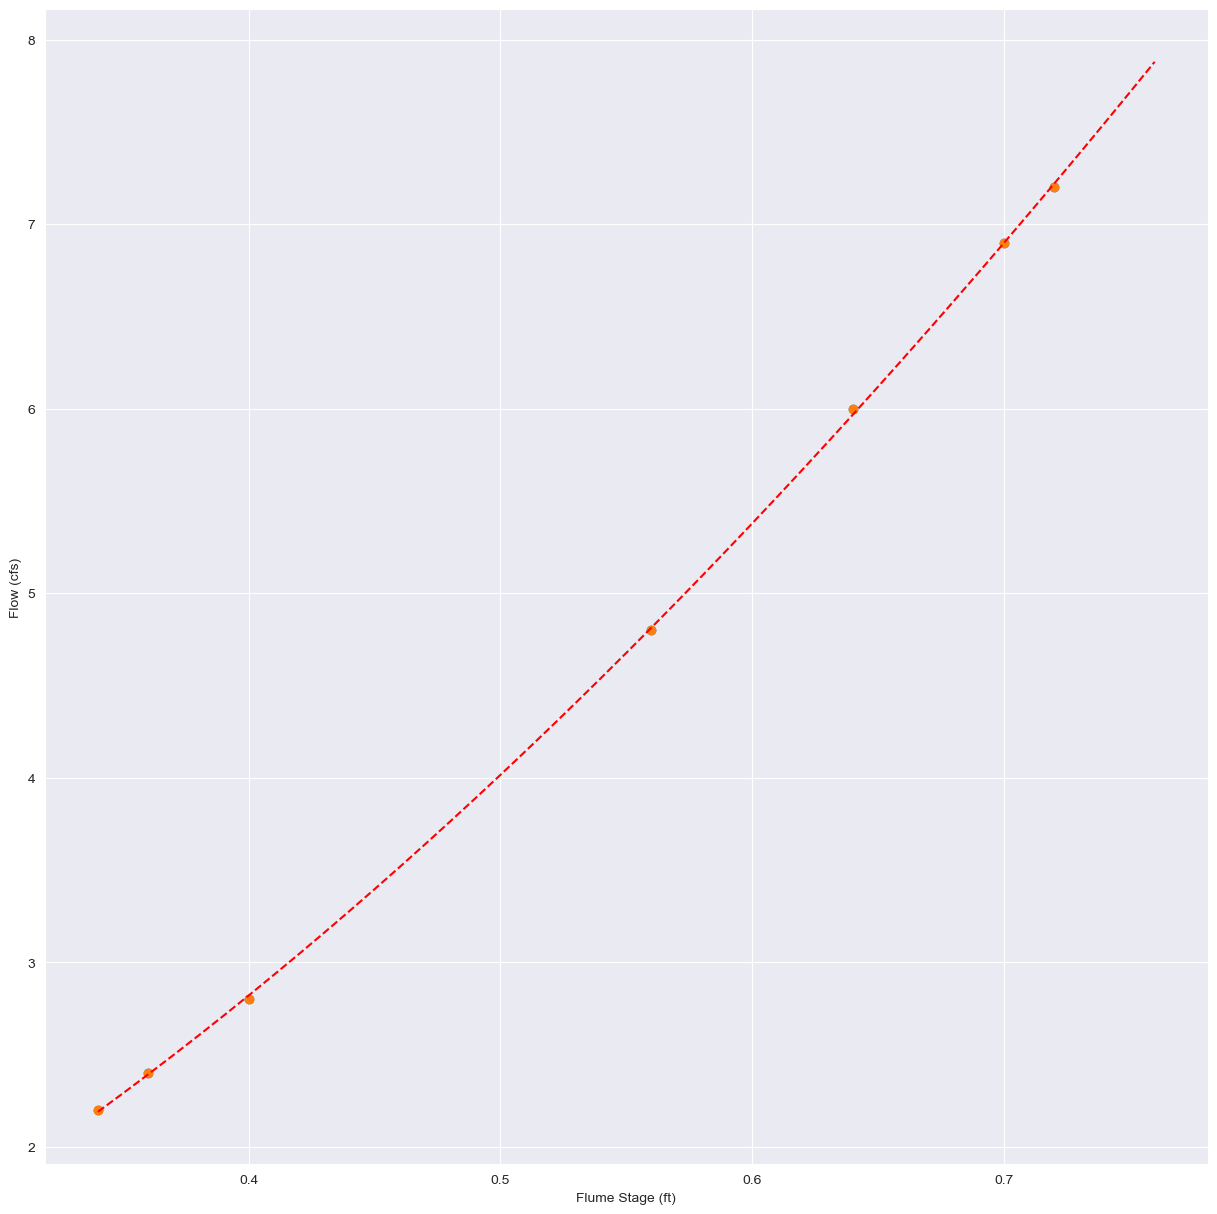

In [11]:



x = stg_dis['Stage']
y = stg_dis['Flow']

plt.scatter(x,y)

def objective(x, a, b,c):
    return a * x ** b+c
 

# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c = popt
print(popt)
# plot input vs output
plt.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = np.arange(min(x), max(x)+0.05, 0.01)
# calculate the output for the range
y_line = objective(x_line, a, b, c)
# create a line plot for the mapping function
plt.plot(x_line, y_line, '--', color='red')

zubeck['Flow'] = a* zubeck['Stage'] ** b + c

zubeck['wateryear'] = zubeck.index.shift(-9,freq='ME').year+1
plt.ylabel('Flow (cfs)')
plt.xlabel('Flume Stage (ft)')
#clear_lake_hist_zb = pd.concat([clear_lake_hist,zubeck],axis=0)

In [12]:
clear_lake_hist_zb = pd.concat([clr_lake_flow,zubeck.loc['2018-11-30':,['Flow','wateryear']]],axis=0)

In [13]:
fig = px.line(clear_lake_hist_zb, y='Flow')
fig.show()

Print the peak springflow for each year and the date that the peak flow occured.

In [14]:
df = clear_lake_hist_zb
df['Date'] = df.index
idx = df.groupby(lambda x: df['Date'][x].year)['Flow'].idxmax()

out = df.loc[idx]
out['doy'] = out.index.dayofyear
print(f"Median doy {out['doy'].median()}")
print(pd.to_datetime(2022 * 1000 + out['doy'].median(), format='%Y%j'))
out.tail()

Median doy 122.5
2022-05-02 00:00:00


,Flow,cond,wateryear,RollingMean,IsOutlier,Date,doy
Date,,,,,,,
2018-06-02,7.200000,NaN,2018.0,5.591667,False,2018-06-02,153
2019-07-10,8.218911,NaN,2019.0,NaN,NaN,2019-07-10,191
2020-05-07,10.000167,NaN,2020.0,NaN,NaN,2020-05-07,128
2021-05-29,5.669343,NaN,2021.0,NaN,NaN,2021-05-29,149
2022-05-01,1.807270,NaN,2022.0,NaN,NaN,2022-05-01,121


## Specific Conductance Plot

In [15]:
fig = px.line(clear_lake_usgs.dropna(subset=['cond']), y='cond')
fig.show()

## Monthly and Annual Flows

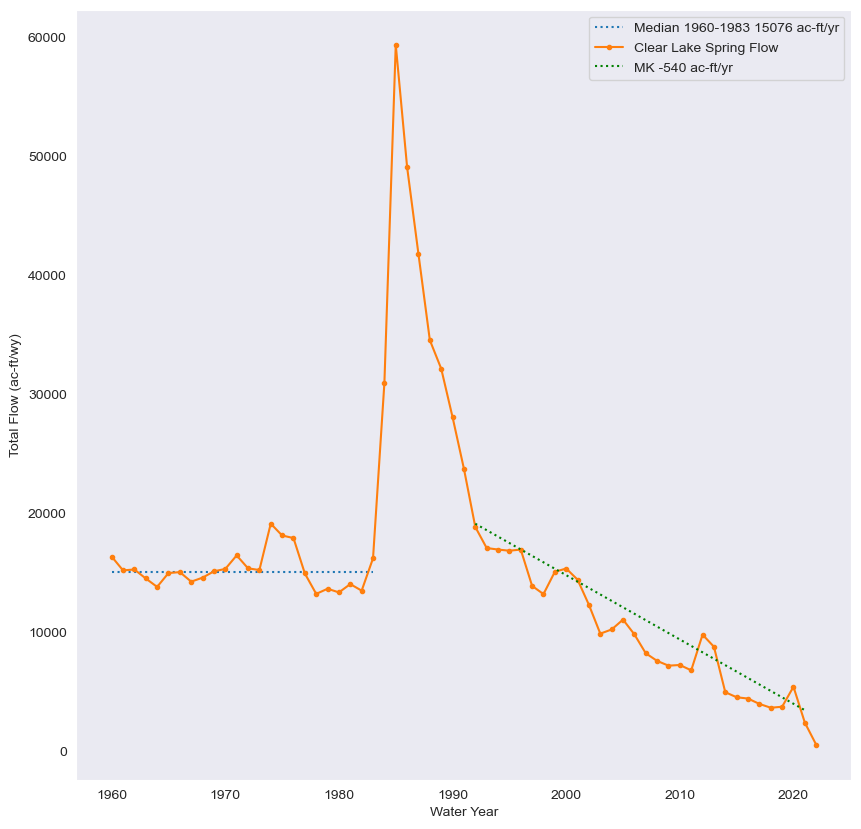

In [16]:
avg_Q = clear_lake_hist_zb.drop(['RollingMean','IsOutlier','Date','cond'],axis=1).resample('1ME').mean().interpolate(method='linear')
avg_Q['wateryear'] = avg_Q.index.shift(-9,freq='ME').year+1
avg_Q['Flow_cfm'] = avg_Q['Flow']*2.628e+6
avg_Q['month'] = avg_Q.index.month
avg_Q_m = avg_Q.resample('MS').mean()#['Flow_cfm']*2.29569e-5
avg_Q_m['spring_flow_acft'] = avg_Q_m['Flow_cfm']*2.29569e-5

flow_wy = avg_Q.groupby('wateryear').sum(numeric_only=True)#
flow_cy = avg_Q.groupby(avg_Q.index.year).sum(numeric_only=True)
flow_cy['ac-ft/yr'] = flow_cy['Flow_cfm']*2.29569e-5
flow_wy['ac-ft/wy'] = flow_wy['Flow_cfm']*2.29569e-5
flow_wy = flow_wy.loc[1960:]

fig, ax = plt.subplots(1,1,figsize=[10,10])

ax.plot([1960,1983],[flow_wy.loc[1960:1981,'ac-ft/wy'].median()]*2, linestyle=":", label=f"Median 1960-1983 {flow_wy.loc[1960:1981,'ac-ft/wy'].median():0.0f} ac-ft/yr")

ax.plot(flow_wy.index, flow_wy['ac-ft/wy'], marker='.', label="Clear Lake Spring Flow")
plotmk(flow_wy.loc[1992:,'ac-ft/wy'],ax,units='ac-ft/yr',color='green')

ax.set_ylabel("Total Flow (ac-ft/wy)")
ax.set_xlabel("Water Year")
plt.grid()
plt.legend()

flow_wy.to_csv(main_path / "Flow Monitoring/clear_lake_spring_flow_wy.csv")
flow_cy.to_csv(main_path / "Flow Monitoring/clear_lake_spring_flow_cy.csv")
avg_Q_m.to_csv(main_path / "Flow Monitoring/clear_lake_spring_flow_mo.csv")
plt.savefig(figure_dir / "clear_lake_flow_by_wy.pdf")
plt.savefig(figure_dir / "clear_lake_flow_by_wy.png")
plt.savefig(figure_dir / "clear_lake_flow_by_wy.svg")

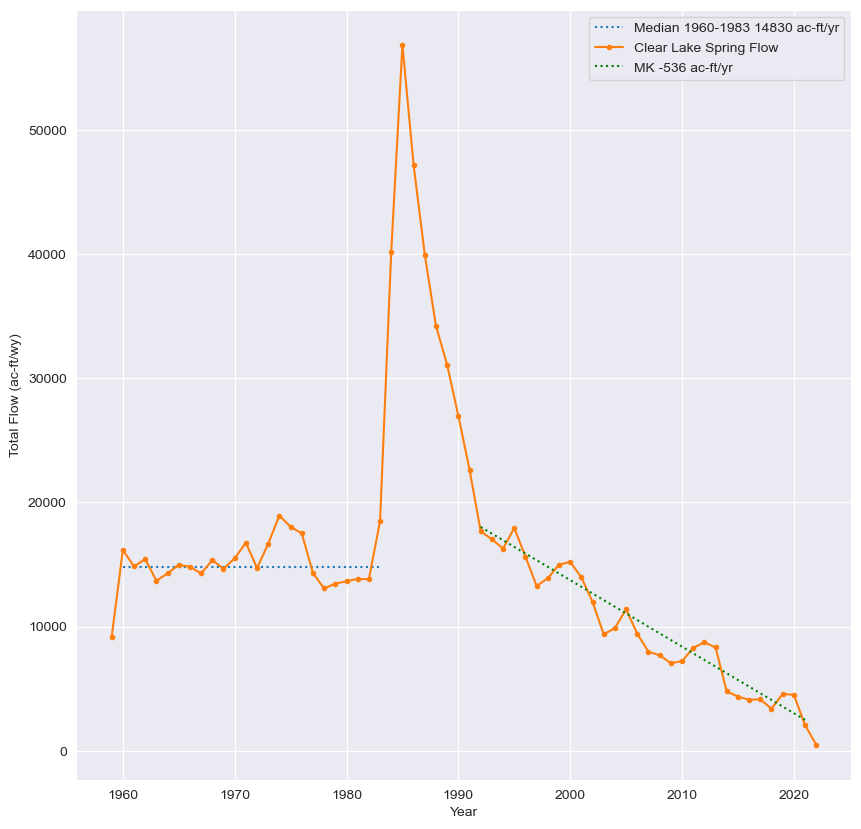

In [17]:
flow_cy['ac-ft/yr']

fig, ax = plt.subplots(1,1,figsize=[10,10])

ax.plot([1960,1983],[flow_cy.loc[1960:1981,'ac-ft/yr'].median()]*2, linestyle=":", 
        label=f"Median 1960-1983 {flow_cy.loc[1960:1981,'ac-ft/yr'].median():0.0f} ac-ft/yr")

ax.plot(flow_cy.index, flow_cy['ac-ft/yr'], marker='.', label="Clear Lake Spring Flow")
plotmk(flow_cy.loc[1992:,'ac-ft/yr'],ax,units='ac-ft/yr',color='green')

ax.set_ylabel("Total Flow (ac-ft/wy)")
ax.set_xlabel("Year")
#plt.grid()
plt.legend()
plt.savefig(figure_dir / "clear_lake_flow_by_cy.pdf")
plt.savefig(figure_dir / "clear_lake_flow_by_cy.png")
plt.savefig(figure_dir / "clear_lake_flow_by_cy.svg")

In [18]:
flow_cy.tail()

,Flow,wateryear,Flow_cfm,month,ac-ft/yr
Date,,,,,
2018,56.112077,24219,1.474625e+08,78,3385.282761
2019,75.791940,24231,1.991812e+08,78,4572.583301
2020,74.672618,24243,1.962396e+08,78,4505.053770
2021,34.323536,24255,9.020225e+07,78,2070.764063
2022,8.021874,16176,2.108148e+07,36,483.965540


## Monthly Data Summary

[ 3.16277508  5.55987952 20.5714995 ]
[ 5.63199229  4.97815103 12.7879945 ]


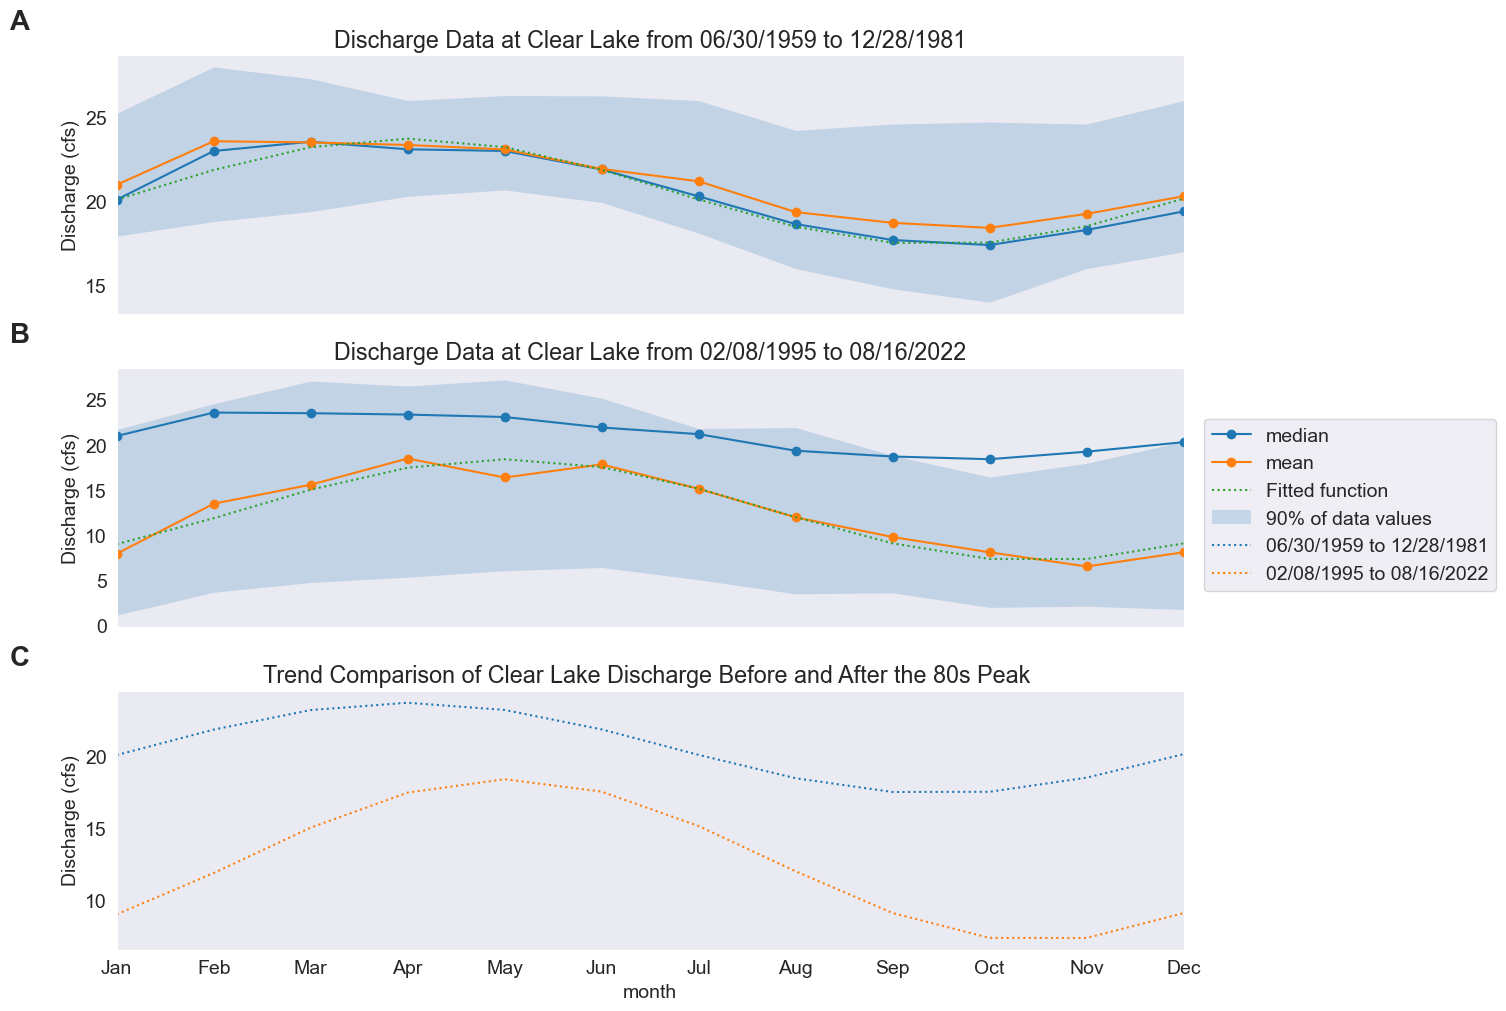

In [19]:
import string
clear_lake_hist_zb.loc[:,'doy'] =clear_lake_hist_zb.index.dayofyear
clear_lake_hist_zb['ones'] = 1
clear_lake_hist_zb['water year doy'] = clear_lake_hist_zb.groupby('wateryear')['ones'].cumsum()
clear_lake_hist_zb['month'] = clear_lake_hist_zb.index.month

old_cl = clear_lake_hist_zb.loc[:'1982-01-01']
new_cl = clear_lake_hist_zb.loc['1995-01-01':]

summaryxn = new_cl['Flow']

minQn = min(summaryxn)
maxQn = max(summaryxn)
meanQn = np.mean(summaryxn)
medianQn = np.median(summaryxn)
stdQn = np.std(summaryxn)

grpd = old_cl.groupby(['month'])['Flow']
xmo = grpd.median().index
ymo = grpd.median()
yao = grpd.mean()
y1o = grpd.quantile(q=0.05)
y2o = grpd.quantile(q=0.95)

grpd = new_cl.groupby(['month'])['Flow']
xmn = grpd.median().index
ymn = grpd.median()
yan = grpd.mean()
y1n = grpd.quantile(q=0.05)
y2n = grpd.quantile(q=0.95)


rcParams.update(inline_rc)
rcParams['figure.figsize'] = 15, 10
rcParams['font.size'] = 14
rcParams['pdf.fonttype'] = 42


def test_func(x, a, b,c):
    return a * np.sin(x*1.8/np.pi+b) + c

old_params, old_params_covariance = curve_fit(test_func, xmo, ymo, p0=[1,6,20], bounds=[(0,1,0),(100,12,40)])
params, params_covariance = curve_fit(test_func, xmn, ymn, p0=[1,6,20], bounds=[(0,1,0),(100,12,40)])

print(old_params)
print(params)

fig, ax = plt.subplots(3,1,sharex=True,layout='constrained')

ax[0].plot(xmo,ymo, label='median',marker="o")
ax[0].plot(xmo,yao, label='mean',marker="o")
ax[1].plot(xmo,yao, marker="o")
ax[1].plot(xmn,ymn, marker="o")

ax[0].plot(xmo, test_func(xmo, old_params[0], old_params[1], old_params[2]), label='Fitted function', linestyle=':')
ax[1].plot(xmn, test_func(xmn, params[0], params[1], params[2]), linestyle=':')

ax[0].fill_between(xmo,y1o,y2o, label='90% of data values', alpha=0.2, linewidth=0)
ax[1].fill_between(xmn,y1n,y2n, alpha=0.2, linewidth=0)

ax[0].set_title("Discharge Data at {:} from {:%m/%d/%Y} to {:%m/%d/%Y}".format('Clear Lake',
                                                                                                  old_cl.index.min(),
                                                                                                  old_cl.index.max()))
ax[1].set_title("Discharge Data at {:} from {:%m/%d/%Y} to {:%m/%d/%Y}".format('Clear Lake', 
                                                                                           new_cl.index.min(),
                                                                                           new_cl.index.max()))
ax[2].set_title("Trend Comparison of {:} Discharge Before and After the 80s Peak ".format('Clear Lake',
                                                                                                  new_cl.index.min(),
                                                                                                  new_cl.index.max()))

summaryxn = new_cl['Flow']

minQn = min(summaryxn)
maxQn = max(summaryxn)
meanQn = np.mean(summaryxn)
medianQn = np.median(summaryxn)
stdQn = np.std(summaryxn)

ax[0].grid()
ax[1].grid()

ax[0].set_ylabel('Discharge (cfs)')
ax[1].set_ylabel('Discharge (cfs)')

old_label = "{:%m/%d/%Y} to {:%m/%d/%Y}".format(old_cl.index.min(),old_cl.index.max())
new_label = "{:%m/%d/%Y} to {:%m/%d/%Y}".format(new_cl.index.min(),new_cl.index.max())

ax[2].plot(xmo, test_func(xmo, old_params[0], old_params[1], old_params[2]), label=old_label, linestyle=':')
ax[2].plot(xmn, test_func(xmn, params[0], params[1], params[2]), label=new_label, linestyle=':')
ax[2].grid()
ax[2].set_ylabel('Discharge (cfs)')

ax[2].set_xlabel('month')
dtrng = pd.date_range('1/1/2014','12/31/2014',freq='1ME')
datelabels = [d.strftime('%b') for d in dtrng]
ax[2].set_xticks(range(1,13,1), datelabels)#dtrng)#,rotation=90)
ax[2].set_xlim(1,12)

for n, axis in enumerate(ax):
    axis.text(-0.1, 1.1, string.ascii_uppercase[n], transform=axis.transAxes,
            size=20, weight='bold')

fig.legend(loc='outside right center')
plt.savefig(figure_dir / 'ClearLakeMonthlyHydroGraph.svg')
plt.savefig(figure_dir / 'ClearLakeMonthlyHydroGraph.pdf')
plt.savefig(figure_dir / 'ClearLakeMonthlyHydroGraph.png')

# Pumping

## Import data 

In [20]:
pumping = pd.read_excel(pumpdata,index_col='Year')

## Cross Correlation

Check correlation between spring flow and pumping.  Determine cross correlation between pumping and springflow by shifting the pumping dataset.

In [21]:
pumpfl = pd.concat([pumping['New_USGS'],flow_cy['ac-ft/yr'],flow_wy['ac-ft/wy']],axis=1).dropna()
pumpfl[f'New_USGS_shift+1'] = pumpfl['New_USGS'].shift(1)
pumpfl[f'New_USGS_shift+2'] = pumpfl['New_USGS'].shift(2)
pumpfl[f'New_USGS_shift+3'] = pumpfl['New_USGS'].shift(3)

#plt.scatter(pumpfl[f'New_USGS_shift+2'],pumpfl['ac-ft/wy'])
pumpfl.corr()

,New_USGS,ac-ft/yr,ac-ft/wy,New_USGS_shift+1,New_USGS_shift+2,New_USGS_shift+3
New_USGS,1.000000,-0.627148,-0.580584,0.810508,0.738961,0.704832
ac-ft/yr,-0.627148,1.000000,0.990318,-0.720139,-0.738913,-0.663336
ac-ft/wy,-0.580584,0.990318,1.000000,-0.700761,-0.741721,-0.674693
New_USGS_shift+1,0.810508,-0.720139,-0.700761,1.000000,0.773528,0.737149
New_USGS_shift+2,0.738961,-0.738913,-0.741721,0.773528,1.000000,0.775112
New_USGS_shift+3,0.704832,-0.663336,-0.674693,0.737149,0.775112,1.000000


In [22]:
bins = np.arange(1959,2040,10)
bins


array([1959, 1969, 1979, 1989, 1999, 2009, 2019, 2029, 2039])

In [23]:

len(np.array([[i]*10 for i in np.arange(1960,2040,10)]).flatten()

SyntaxError: incomplete input (1469232715.py, line 1)

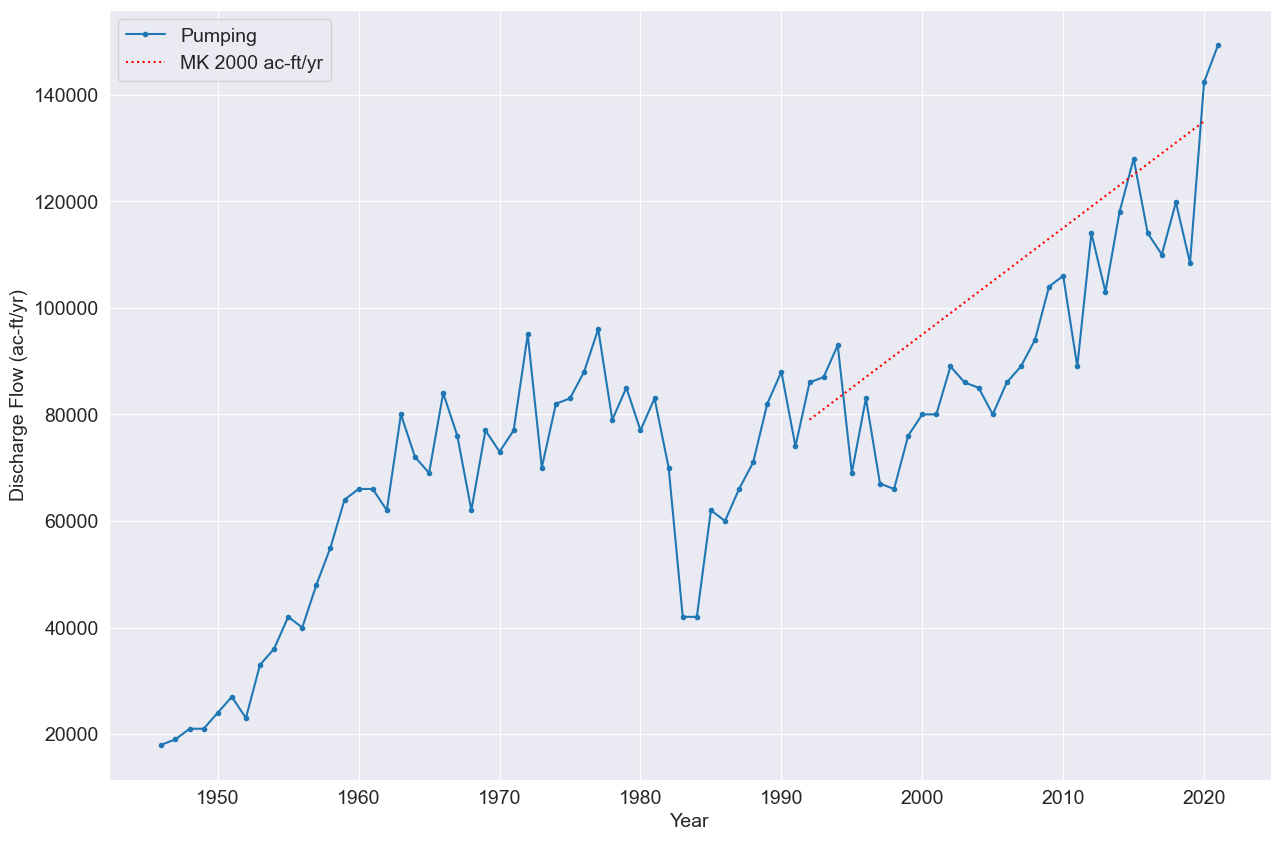

In [24]:
fig, ax = plt.subplots(1,1)
pumping['New_USGS'].plot(marker='.',ax=ax, label='Pumping')

plotmk(pumping.loc[1992:,'New_USGS'],ax,units='ac-ft/yr',color=None)
ax.legend()
ax.set_ylabel('Discharge Flow (ac-ft/yr)')
ax.set_xlabel('Year')
plt.savefig(figure_dir / 'USGS_Pumping_Rates.svg')
plt.savefig(figure_dir / 'USGS_Pumping_Rates.pdf')
plt.savefig(figure_dir / 'USGS_Pumping_Rates.jpg')

14830.048354725
15302.696039063216


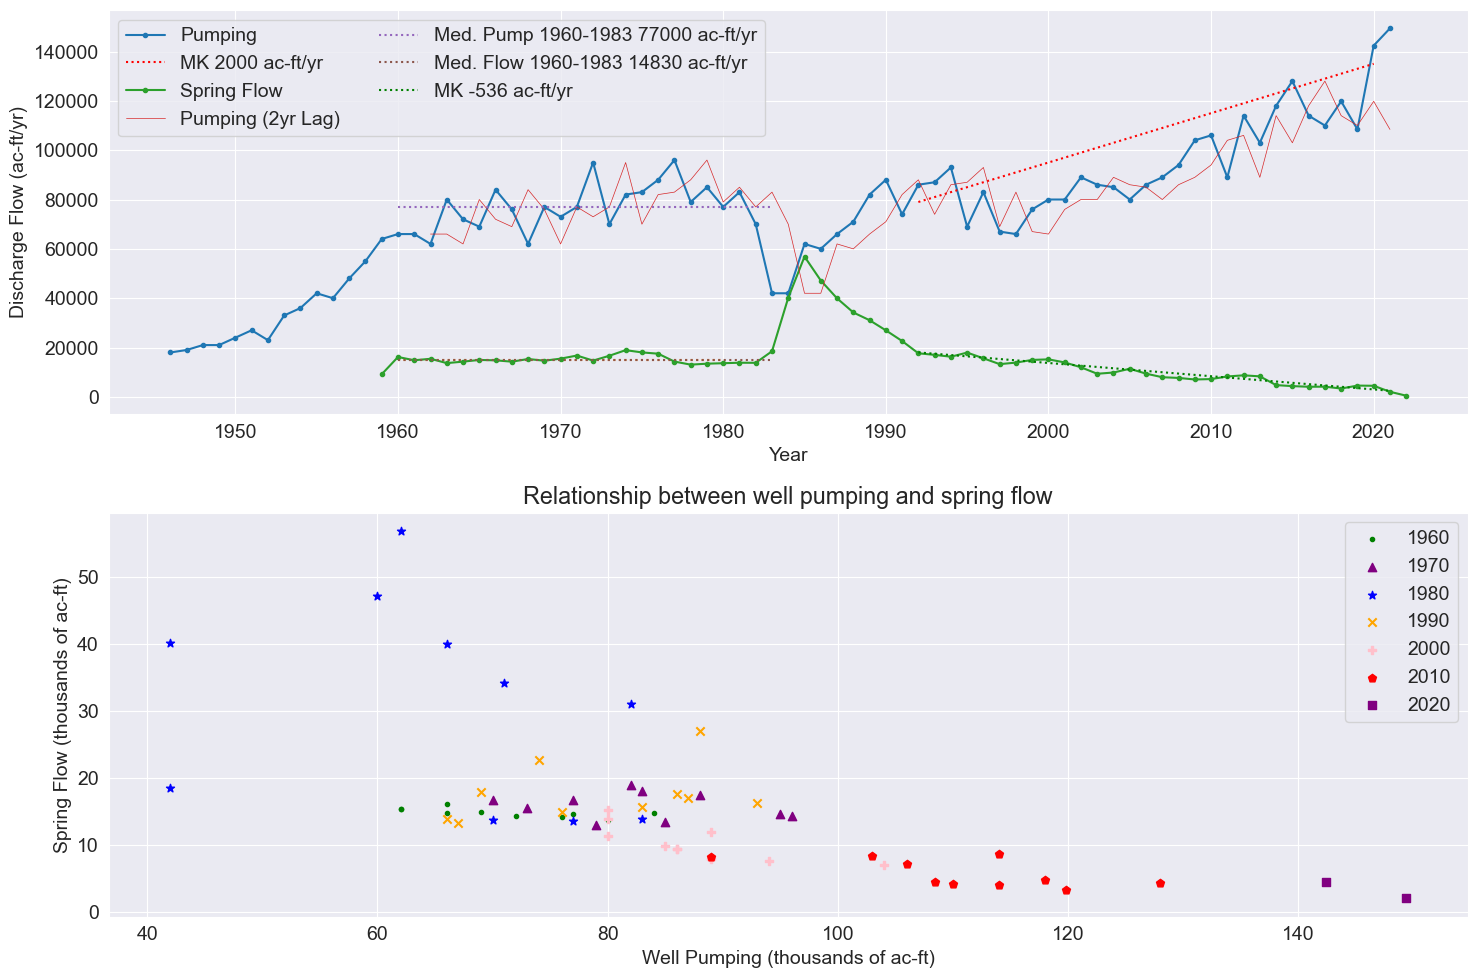

In [25]:
fig, ax = plt.subplots(2,1)

pumping['New_USGS'].plot(marker='.',label='Pumping',ax=ax[0])
plotmk(pumping.loc[1992:,'New_USGS'],ax[0],units='ac-ft/yr',color=None)
ax[0].plot([1960,1980],[flow_cy.loc[1960:1981,'ac-ft/yr'].median()]*2,linestyle=":")
print(flow_cy.loc[1960:1983,'ac-ft/yr'].median())
print(flow_cy.loc[1960:1983,'ac-ft/yr'].mean())
#flow_wy['ac-ft/wy'].plot(marker='.',label='Spring Flow')
flow_cy['ac-ft/yr'].plot(marker='.',label='Spring Flow',ax=ax[0])
pumpfl[f'New_USGS_shift+2'].plot(label='Pumping (2yr Lag)',linewidth=0.5,ax=ax[0])

medianpump = pumping.loc[1960:1981,'New_USGS'].median()
ax[0].plot([1960,1983], [medianpump]*2, linestyle=":", label=f"Med. Pump 1960-1983 {medianpump:0.0f} ac-ft/yr")

ax[0].plot([1960,1983],[flow_cy.loc[1960:1981,'ac-ft/yr'].median()]*2, linestyle=":",
        label=f"Med. Flow 1960-1983 {flow_cy.loc[1960:1981,'ac-ft/yr'].median():0.0f} ac-ft/yr")
plotmk(flow_cy.loc[1992:,'ac-ft/yr'],ax[0],units='ac-ft/yr',color='green')

#plt.grid()
ax[0].legend(ncols=2)
ax[0].set_ylabel('Discharge Flow (ac-ft/yr)')
ax[0].set_xlabel('Year')

df = pumpfl[[f'New_USGS_shift+2','ac-ft/wy']].dropna()

#(df.index>1992)]

x = df[f'New_USGS_shift+2']
y = df['ac-ft/wy']



# Fit the function a * np.exp(b * t) + c to x and y
def expfun(t, a,b,c):
    return a * t**-b + c

#def expfun(t, a,b):
#    return a * t + b 

popt, pcov = curve_fit(expfun, x, y, p0=[1300000,0.29,0],maxfev = 8000)

a = popt[0]
b = popt[1]
c = popt[2]
# Create the fitted curve
x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = expfun(x_fitted, a,b,c)


pumpfl['Well Pumping (k ac-ft/yr'] = pumpfl['New_USGS']/1000
pumpfl['Spring Flow (k ac-ft/yr'] = pumpfl['ac-ft/yr']/1000
pumpfl['Decade'] = (pumpfl.index//10)*10

x = pumpfl['Well Pumping (k ac-ft/yr']
y = pumpfl['Spring Flow (k ac-ft/yr']

markers = {1960:'.', 1970:'^', 1980:'*', 1990:'x', 2000:'P', 2010:'p', 2020:'s'}
color = {1960:'green', 1970:'purple', 1980:'blue', 1990:'orange', 2000:'pink', 2010:'red', 2020:'purple'}
for decade, d in pumpfl.groupby('Decade'):
    ax[1].scatter(x=d['Well Pumping (k ac-ft/yr'], y=d['Spring Flow (k ac-ft/yr'],  color=color[decade],marker=markers[decade], label=decade)
#plt.legend()
#ax[1].scatter(x, y, label='Raw data')
#ax[1].plot(x_fitted, y_fitted, 'k', label='Fitted curve')
ax[1].set_title(r'Relationship between well pumping and spring flow')
ax[1].set_xlabel('Well Pumping (thousands of ac-ft)')
ax[1].set_ylabel('Spring Flow (thousands of ac-ft)')
ax[1].legend()

fig.tight_layout()

plt.savefig(figure_dir / "22 - pumping_spring_cy.pdf")
plt.savefig(figure_dir / "22 - pumping_spring_cy.png")
plt.savefig(figure_dir / "22 - pumping_spring_cy.svg")

## Check significant trends over time

In [23]:
pumping

,Datetime,New_USGS,Total Wells,>=12in,Irrigation,Industrial1,Public Supply,Domestic and Stock,Total
Year,,,,,,,,,
1946,1946,18000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947,1947,19000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948,1948,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949,1949,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950,1950,24000,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...
2017,2017-09-30 00:00:00,110000,7.0,3.0,108900.0,0.0,1000.0,320.0,110220.0
2018,2018-09-30 00:00:00,119806,4.0,3.0,118455.0,0.0,1031.0,320.0,119806.0
2019,2019-09-30 00:00:00,108425,8.0,1.0,107191.0,0.0,914.0,320.0,108425.0


KeyError: 'ac-ft/yr'

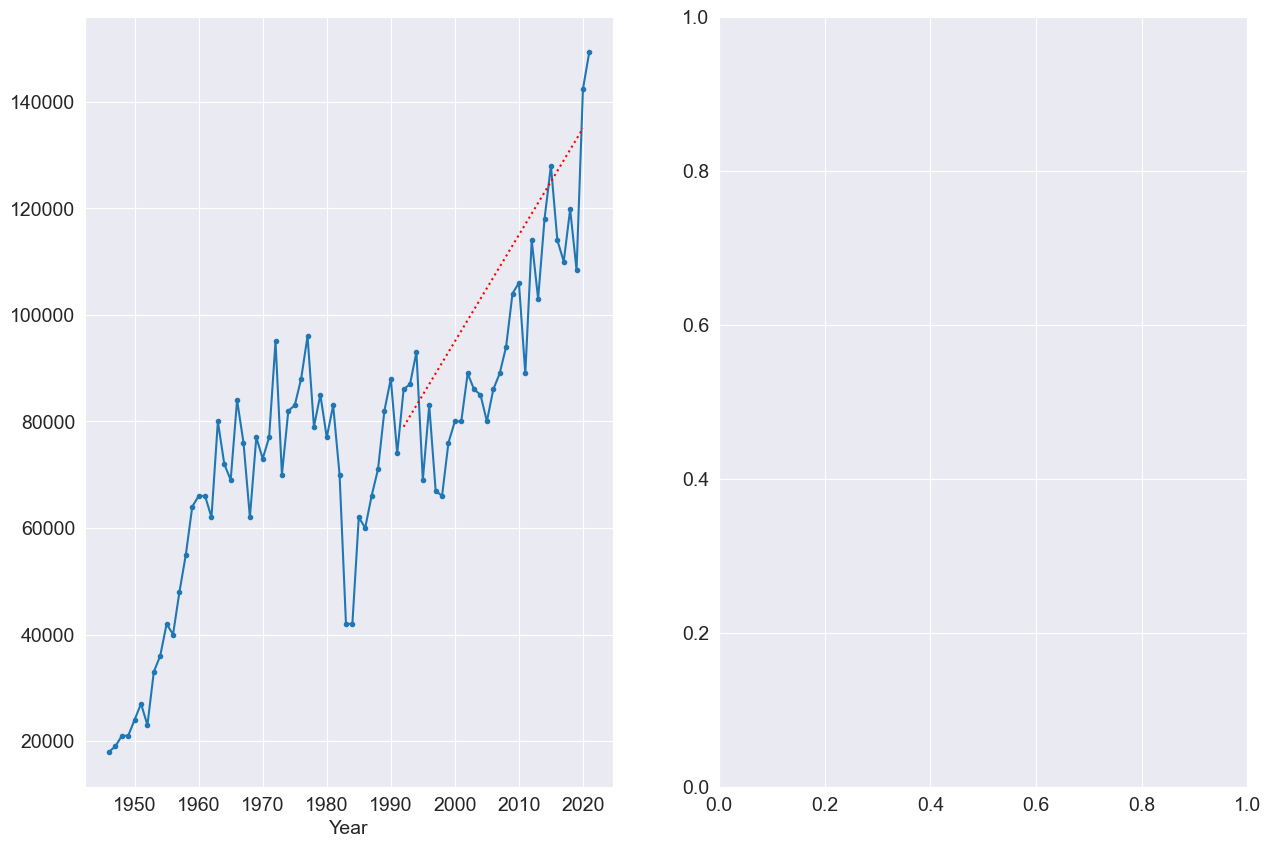

In [24]:


fig, ax = plt.subplots(1,2)
pumping['New_USGS'].plot(ax=ax[0],marker='.') 
plotmk(pumping.loc[1992:,'New_USGS'],ax[0],units='ac-ft/yr',color=None)
medianpump = pumping.loc[1960:1981,'ac-ft/yr'].median()
plt.plot([1960,1983], [medianpump]*2, linestyle=":", label=f"Median 1960-1983 {medianpump:0.0f} ac-ft/yr")
ax.set_ylabel("Groundwater Pumping (ac-ft/yr)")

df = pumpfl[[f'New_USGS_shift+2','ac-ft/wy']].dropna()

x = df[f'New_USGS_shift+2']
y = df['ac-ft/wy']



# Fit the function a * np.exp(b * t) + c to x and y
def expfun(t, a,b,c):
    return a * t**-b + c

popt, pcov = curve_fit(expfun, x, y, p0=[1300000,0.29,0],maxfev = 8000)

a = popt[0]
b = popt[1]
c = popt[2]
# Create the fitted curve
x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = a * x_fitted **-b+ c

ax[1].scatter(x, y, label='Raw data')
ax[1].plot(x_fitted, y_fitted, 'k', label='Fitted curve')
ax[1].set_title(r'Relationship between well pumping and spring flow')
ax[1].set_xlabel('Well Pumping (ac-ft) lagged 2 years')
ax[1].set_ylabel('Spring Flow (ac-ft)')
ax[1].legend()


plt.legend()
plt.grid()

## Relationships

Estimate relationships between springflow and pumping.

93241015356835.02 1.997025556708414 -537.4574511650013


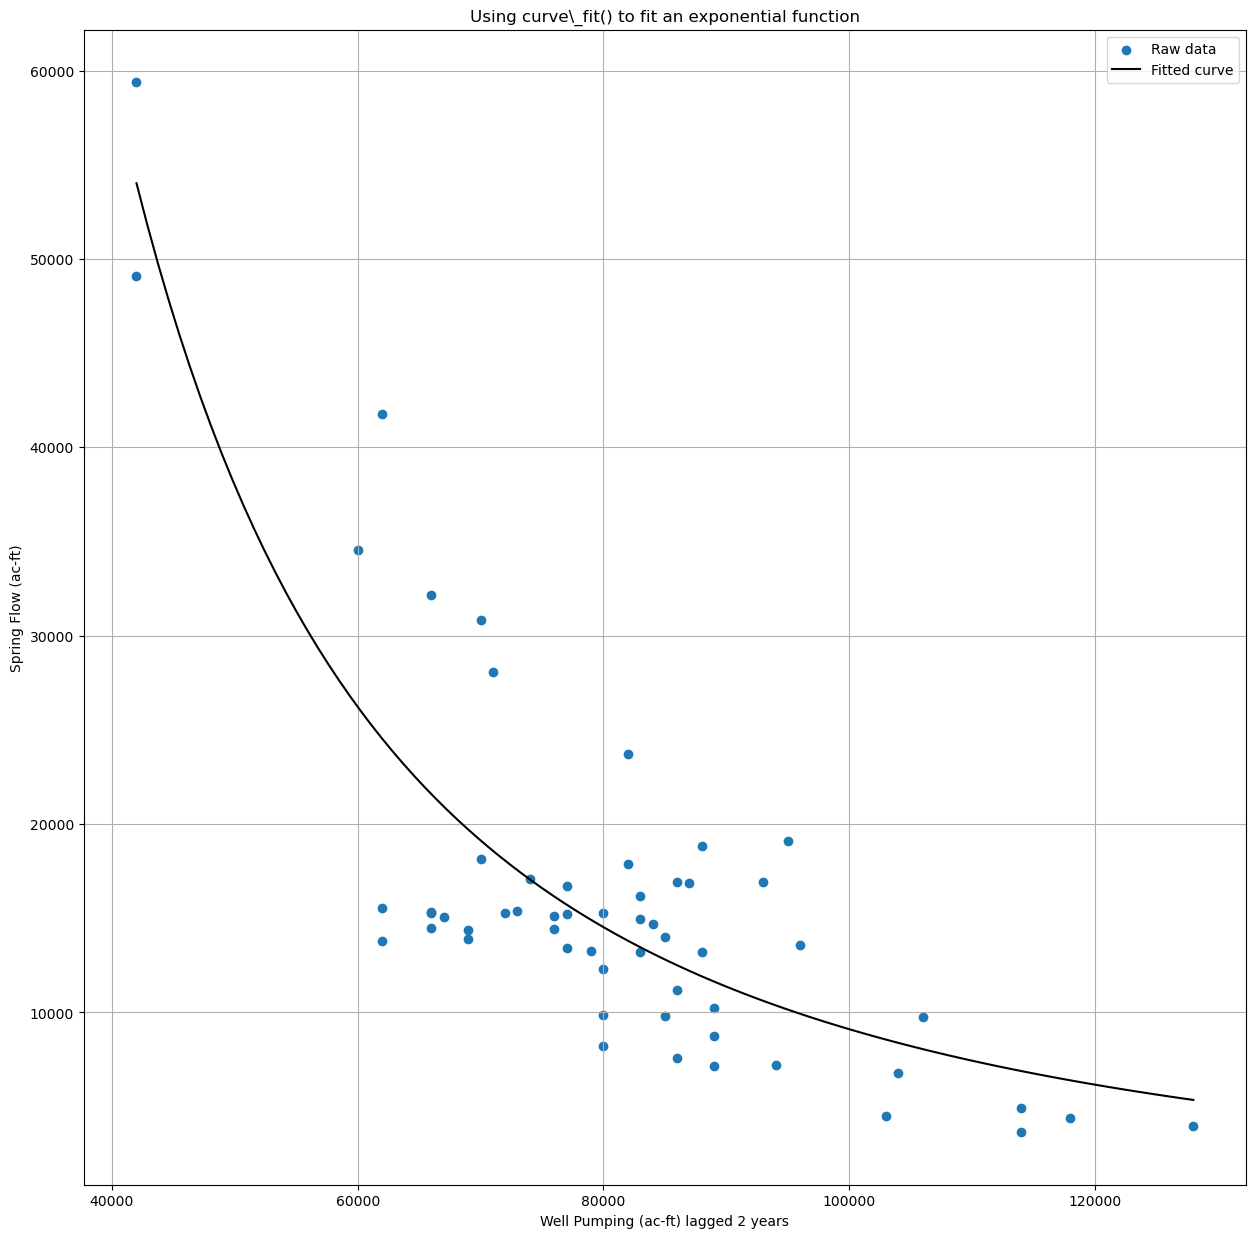

In [167]:


# https://rowannicholls.github.io/python/curve_fitting/exponential.html
#x = np.arange(pumpfl[f'New_USGS_shift+2'].min(),pumpfl[f'New_USGS_shift+2'].max(),1000)
#y = [1354771.2286*i**(-0.297109) for i in x]
df = pumpfl[[f'New_USGS_shift+2','ac-ft/wy']].dropna()

x = df[f'New_USGS_shift+2']
y = df['ac-ft/wy']



# Fit the function a * np.exp(b * t) + c to x and y
def expfun(t, a,b,c):
    return a * t**-b + c

popt, pcov = curve_fit(expfun, x, y,p0=[1300000,0.29,0],maxfev = 8000)

a = popt[0]
b = popt[1]
c = popt[2]
# Create the fitted curve
x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = a * x_fitted **-b+ c

# Plot
fig, ax = plt.subplots(1,1)
ax.scatter(x, y, label='Raw data')
ax.plot(x_fitted, y_fitted, 'k', label='Fitted curve')
ax.set_title(r'Relationship between well pumping and spring flow')
ax.set_xlabel('Well Pumping (ac-ft) lagged 2 years')
ax.set_ylabel('Spring Flow (ac-ft)')
ax.legend()
plt.grid()
print(a,b,c)

# Climate Data

In [31]:
import shutil
zipped_dir = "C:/Users/paulinkenbrandt/Downloads/New folder/"

for file in glob.glob(zipped_dir + "*.zip"):
    shutil.unpack_archive(file, zipped_dir)

In [45]:

dfs = {}
infos = {}

for file in climate_dir.glob("*ghcn*.csv"):
    print(file)
    stationinfo = pd.read_csv(file,nrows=9,skiprows=1,names=['descriptor','value'],index_col=0)
    stationdata = pd.read_csv(file,skiprows=15,index_col='Day',parse_dates=True,na_values=['M','S','T'])
    stationdata['Station ID'] = stationinfo.loc['Station ID'][0]
    station_name = stationinfo.loc['Station Name'][0]
    print(station_name)
    dfs[station_name] = stationdata
    infos[station_name] = stationinfo
weather_stations_data = pd.concat(dfs).drop_duplicates()
weather_stations_metadata = pd.concat(infos).drop_duplicates()

G:\Shared drives\UGS_Groundwater\Projects\Pahvant_Valley\Climate_Station_Data\UCC_ghcn_USC00422828_2022_01_11_1641939174.csv
FILLMORE
G:\Shared drives\UGS_Groundwater\Projects\Pahvant_Valley\Climate_Station_Data\UCC_ghcn_USC00426357_2022_01_11_1641939176.csv
OAK CITY
G:\Shared drives\UGS_Groundwater\Projects\Pahvant_Valley\Climate_Station_Data\UCC_ghcn_USC00422828_2022_01_11_1641939141.csv
FILLMORE
G:\Shared drives\UGS_Groundwater\Projects\Pahvant_Valley\Climate_Station_Data\UCC_ghcn_USC00427714_2022_01_11_1641939149.csv
SCIPIO
G:\Shared drives\UGS_Groundwater\Projects\Pahvant_Valley\Climate_Station_Data\UCC_ghcn_USC00427714_2022_01_11_1641939187.csv
SCIPIO
G:\Shared drives\UGS_Groundwater\Projects\Pahvant_Valley\Climate_Station_Data\UCC_ghcn_USR0000BLAC_2022_01_11_1641939267.csv
BLACK CEDAR - FILMORE 5E UTAH
G:\Shared drives\UGS_Groundwater\Projects\Pahvant_Valley\Climate_Station_Data\UCC_ghcn_USR0000HORS_2022_01_11_1641939278.csv
HORSE HOLLOW - COVE FORT 5W UT
G:\Shared drives\UGS_Gr

In [46]:
weather_stations_data['wateryear'] = weather_stations_data.index.get_level_values(1).shift(-9,freq='M').year+1
all_stations_ppt  = weather_stations_data['Precipitation'].unstack(0).loc['1950-01-01':]

Text(0.5, 0, 'Water Year')

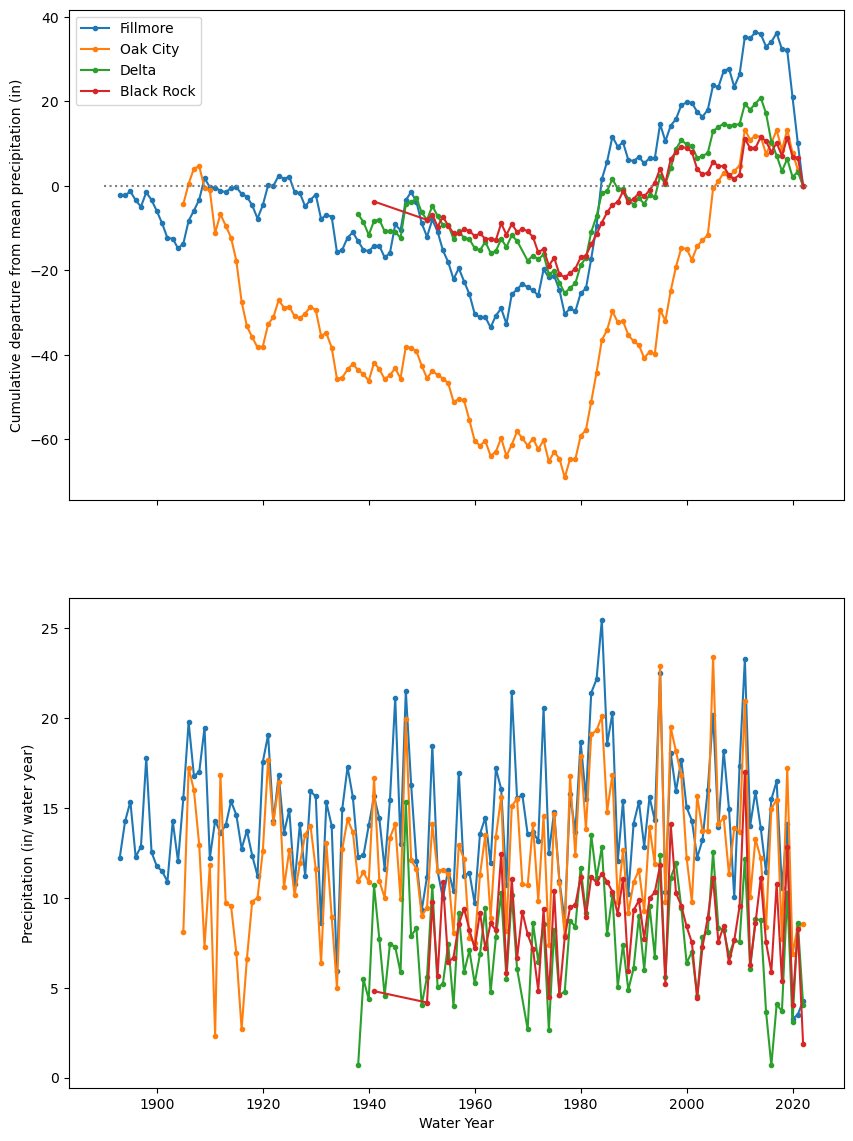

In [47]:
station_nm = 'FILLMORE'

fig, ax = plt.subplots(2,1,figsize=[10,14],sharex=True)

good_stations = ['FILLMORE','OAK CITY','DELTA','BLACK ROCK']


for station_nm in dfs.keys():
    if station_nm in good_stations:
        station_data = weather_stations_data.loc[station_nm,'Precipitation']
        ppt_data = station_data.loc[station_data.first_valid_index():].fillna(0).to_frame()
        ppt_data['Precipitation'] = ppt_data['Precipitation']*0.0393701 # mm to inches
        ppt_data['wateryear'] = ppt_data.index.shift(-9,freq='M').year+1
        ppt_monthly = ppt_data.groupby(pd.Grouper(freq='1M')).sum()
        ppt_wy = ppt_data.groupby('wateryear').sum()
        ppt_wy['cdm'] = (ppt_wy['Precipitation'] - ppt_wy['Precipitation'].mean()).cumsum()
        
        #ppt_monthly['cdm'] = (ppt_monthly['Precipitation'] - ppt_monthly['Precipitation'].mean()).cumsum()
        ax[0].plot(ppt_wy.index,ppt_wy['cdm'],marker='.',label=station_nm.title())
        ax[1].plot(ppt_wy.index,ppt_wy['Precipitation'],marker='.',label=station_nm.title())


ax[0].legend()
ax[0].set_ylabel('Cumulative departure from mean precipitation (in)')
ax[0].hlines(0,1890,2023,linestyle=":",color='grey')

ax[1].set_ylabel('Precipitation (in/ water year)')
ax[1].set_xlabel('Water Year')

In [48]:
all_stations_ppt  = weather_stations_data['Precipitation'].unstack(0).loc['1950-01-01':]

C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_32880\300661552.py:14: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_32880\300661552.py:14: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



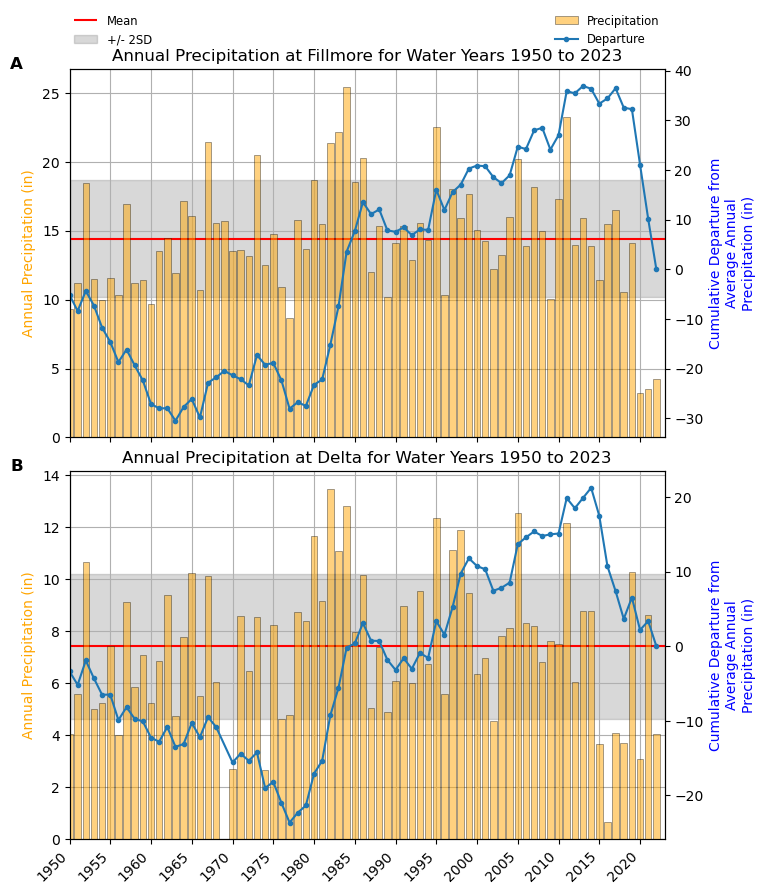

In [49]:
strt = 1950
end = 2023
units = "in"

fix, ax = plt.subplots(2,1, figsize=[8.5,11],sharex=True)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'pdf.fonttype': 42})
ax1 = []

i=0
graph_stations = ['FILLMORE','DELTA']
#ax0 = plt.subplot(211)
for station_nm in graph_stations:
    df_wy = weather_stations_data.loc[station_nm].groupby('wateryear').sum()
    df_wy = df_wy[(df_wy.index >= strt)&(df_wy.index < end)]
    df_wy['Precipitation'] = df_wy['Precipitation']*0.0393701 # mm to inches
    ppt_mean = df_wy['Precipitation'].mean()
    ppt_std = df_wy['Precipitation'].std()
    df_wy['dev_mean_ppt'] = df_wy['Precipitation'] - ppt_mean
    df_wy['cum_dev_mean_ppt'] = df_wy['dev_mean_ppt'].cumsum()

    ax[i].set_title(f"Annual Precipitation at {station_nm.title()} for Water Years {strt} to {end}")
    lns1 = ax[i].bar(df_wy.index,df_wy['Precipitation'],zorder=5,color='orange',alpha=0.5,
                     edgecolor='black',linewidth=0.5, label='Precipitation')

    lns2 = ax[i].hlines(df_wy['Precipitation'].mean(),strt,end,color='red',zorder=3,label='Mean')
    lns3 = ax[i].fill_between([strt,end], ppt_mean - ppt_std, ppt_mean + ppt_std, alpha=0.3,color='grey',label="+/- 2SD")
    #ax[i].set_yticks(range(0,28,2))

    ax1.append(ax[i].twinx())
    lns4 = ax1[i].plot(df_wy.index,df_wy['cum_dev_mean_ppt'],'.-',zorder=0,label = 'Departure')
    ax[i].set_xlim(strt,end)

    ax[i].grid(True)
    ax[i].set_ylabel(f'Annual Precipitation ({units})',color='orange')
    #ax[i].set_ylim(0,1)   
    #ax1[i].set_ylim(-1.0,1.5)    
    #ax[i].set_yticks(np.arange(0,1.1,0.1))
    #ax1[i].set_yticks(np.arange(-1.5,1.8,0.3))        
    ax1[i].set_ylabel(f'Cumulative Departure from\nAverage Annual\nPrecipitation ({units})',color='blue')

    i +=1

ax[i-1].set_xticks(range(strt,end,5))
ax[i-1].set_xticklabels(range(strt,end,5),rotation=45, ha='right')
ax[0].text(-0.1, 1.0, "A", transform=ax[0].transAxes, size=12, weight='bold')
ax[1].text(-0.1, 1.0, "B", transform=ax[1].transAxes, size=12, weight='bold')

plt.subplots_adjust(hspace=0.05)
plt.tight_layout()

# ask matplotlib for the plotted objects and their label        
lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax1[0].get_legend_handles_labels()

#plt.subplots_adjust(bottom=0.15,top=0.85,left=0.15,right=0.85)
#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax[0].legend(lines + lines2, labels + labels2,bbox_to_anchor=(0,1.05,1,0.2), 
             loc="lower left", mode="expand",   borderaxespad=0, ncol=2, fontsize='small',
            frameon=False)
plt.subplots_adjust(bottom=0.15,top=0.85,left=0.15,right=0.85)
#plt.savefig(figure_dir+"02_depart_mean_precip.pdf")
#plt.savefig(figure_dir+"02_depart_mean_precip.png")
#plt.savefig(figure_dir+"02_depart_mean_precip.svg")

## Combine Datasets

,Flow,wateryear,Date
Date,,,
1959-06-01,23.0,1959,1959-06-30
1959-07-01,23.0,1959,1959-07-30
1959-08-01,22.0,1959,1959-08-30
1959-09-01,20.0,1959,1959-09-30
1959-10-01,21.0,1960,1959-10-30
...,...,...,...
2018-07-01,5.7,2018,2018-07-14
2018-08-01,4.6,2018,2018-08-22
2018-09-01,2.8,2018,2018-09-20


In [102]:
clr_lk_mo = clear_lake_hist.resample('1MS').bfill()
flm_ppt_mo = all_stations_ppt['FILLMORE'].groupby(pd.Grouper(freq='1MS')).sum()
ppt_flw_mo = pd.concat([clr_lk_mo,flm_ppt_mo],axis=1).dropna()

C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_32880\500428409.py:73: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



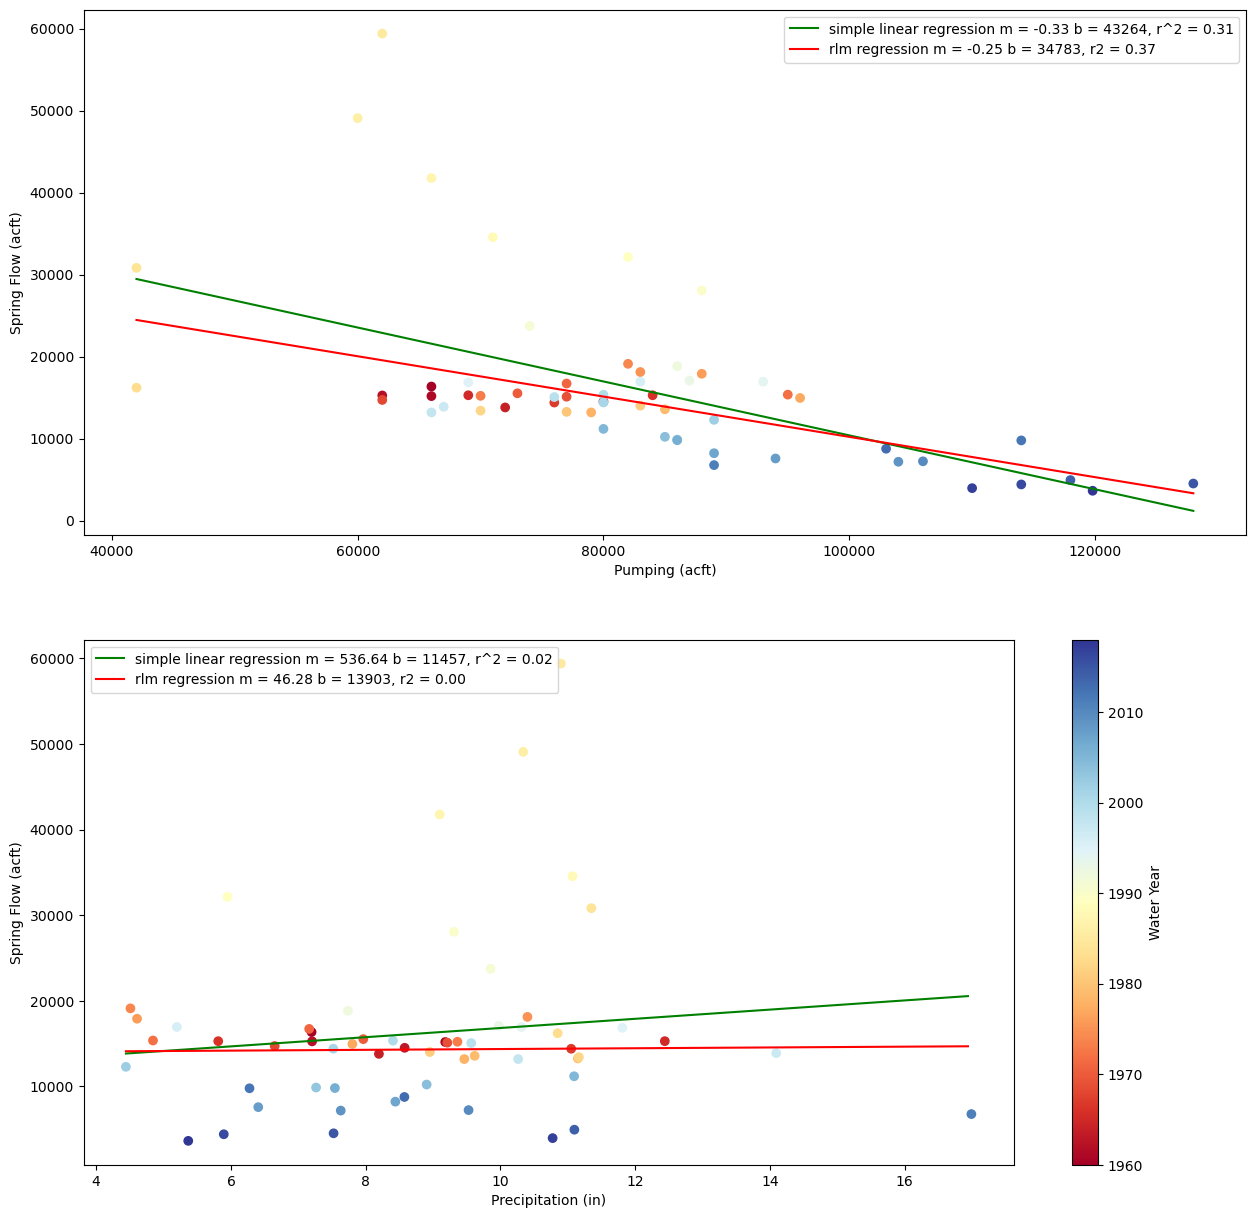

In [93]:
pump_flow_ppt = pd.concat([pumping['New_USGS'],flow_wy['ac-ft/wy'],flow_cy['ac-ft/yr'] ,ppt_wy],axis=1)
pump_flow_ppt = pump_flow_ppt.dropna()
x0_pump = pump_flow_ppt['New_USGS']
x0_ppt = pump_flow_ppt['Precipitation']

y = pump_flow_ppt['ac-ft/wy']

w = pump_flow_ppt.index

fig, ax = plt.subplots(2,1)

cmap = plt.cm.get_cmap('RdYlBu')
norm = mpl.colors.Normalize(vmin=w.min(), vmax=w.max())
m = cm.ScalarMappable(norm=norm, cmap=cmap)
m.set_array(w)


sc_pump = ax[0].scatter(x0_pump, y, label='', color = m.to_rgba(w))
sc_ppt = ax[1].scatter(x0_ppt, y, label='', color = m.to_rgba(w))

xa_pump = sm.add_constant(x0_pump)
xa_ppt = sm.add_constant(x0_ppt)

est_pump = sm.RLM(y, xa_pump).fit()
est_ppt = sm.RLM(y, xa_ppt).fit()

r2_pump = sm.WLS(y, xa_pump, weights=est_pump.weights).fit().rsquared
r2_ppt = sm.WLS(y, xa_ppt, weights=est_ppt.weights).fit().rsquared

slope_pump = est_pump.params[1]
slope_ppt = est_ppt.params[1]

x_prime_pump = np.linspace(np.min(x0_pump),np.max(x0_pump),100)[:, np.newaxis]
x_prime_pump = sm.add_constant(x_prime_pump)
y_hat_pump = est_pump.predict(x_prime_pump)

x_prime_ppt = np.linspace(np.min(x0_ppt),np.max(x0_ppt),100)[:, np.newaxis]
x_prime_ppt = sm.add_constant(x_prime_ppt)
y_hat_ppt = est_ppt.predict(x_prime_ppt)


const_ppt = est_ppt.params[0]
const_pump = est_pump.params[0]

y2_pump = [i*slope_pump + const_pump for i in x0_pump]
y2_ppt = [i*slope_ppt + const_ppt for i in x0_ppt]

ax[0].set_xlabel('Pumping (acft)')
ax[1].set_xlabel('Precipitation (in)')
ax[0].set_ylabel('Spring Flow (acft)')
ax[1].set_ylabel('Spring Flow (acft)')

lin_ppt = linregress(x0_ppt,y)
lin_pump = linregress(x0_pump,y)

x1_ppt = np.arange(np.min(x0_ppt), np.max(x0_ppt),0.1)
x1_pump = np.arange(np.min(x0_pump), np.max(x0_pump),0.1)

y1_ppt = [i*lin_ppt[0]+lin_ppt[1] for i in x1_ppt]
y1_pump = [i*lin_pump[0]+lin_pump[1] for i in x1_pump]

y2_ppt = [i*slope_ppt+const_ppt for i in x1_ppt]
y2_pump = [i*slope_pump+const_pump for i in x1_pump]

ax[0].plot(x1_pump,y1_pump,c='g',label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(lin_pump[0],lin_pump[1],lin_pump[2]**2))
ax[1].plot(x1_ppt,y1_ppt,c='g',label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(lin_ppt[0],lin_ppt[1],lin_ppt[2]**2))

ax[0].plot(x1_pump,y2_pump,c='r',label='rlm regression m = {:.2f} b = {:.0f}, r2 = {:.2f}'.format(slope_pump,const_pump,r2_pump))
ax[1].plot(x1_ppt,y2_ppt,c='r',label='rlm regression m = {:.2f} b = {:.0f}, r2 = {:.2f}'.format(slope_ppt,const_ppt,r2_ppt))

ax[0].legend()
ax[1].legend()
cbar = plt.colorbar(m)

cbar.set_label('Water Year')


<AxesSubplot: >

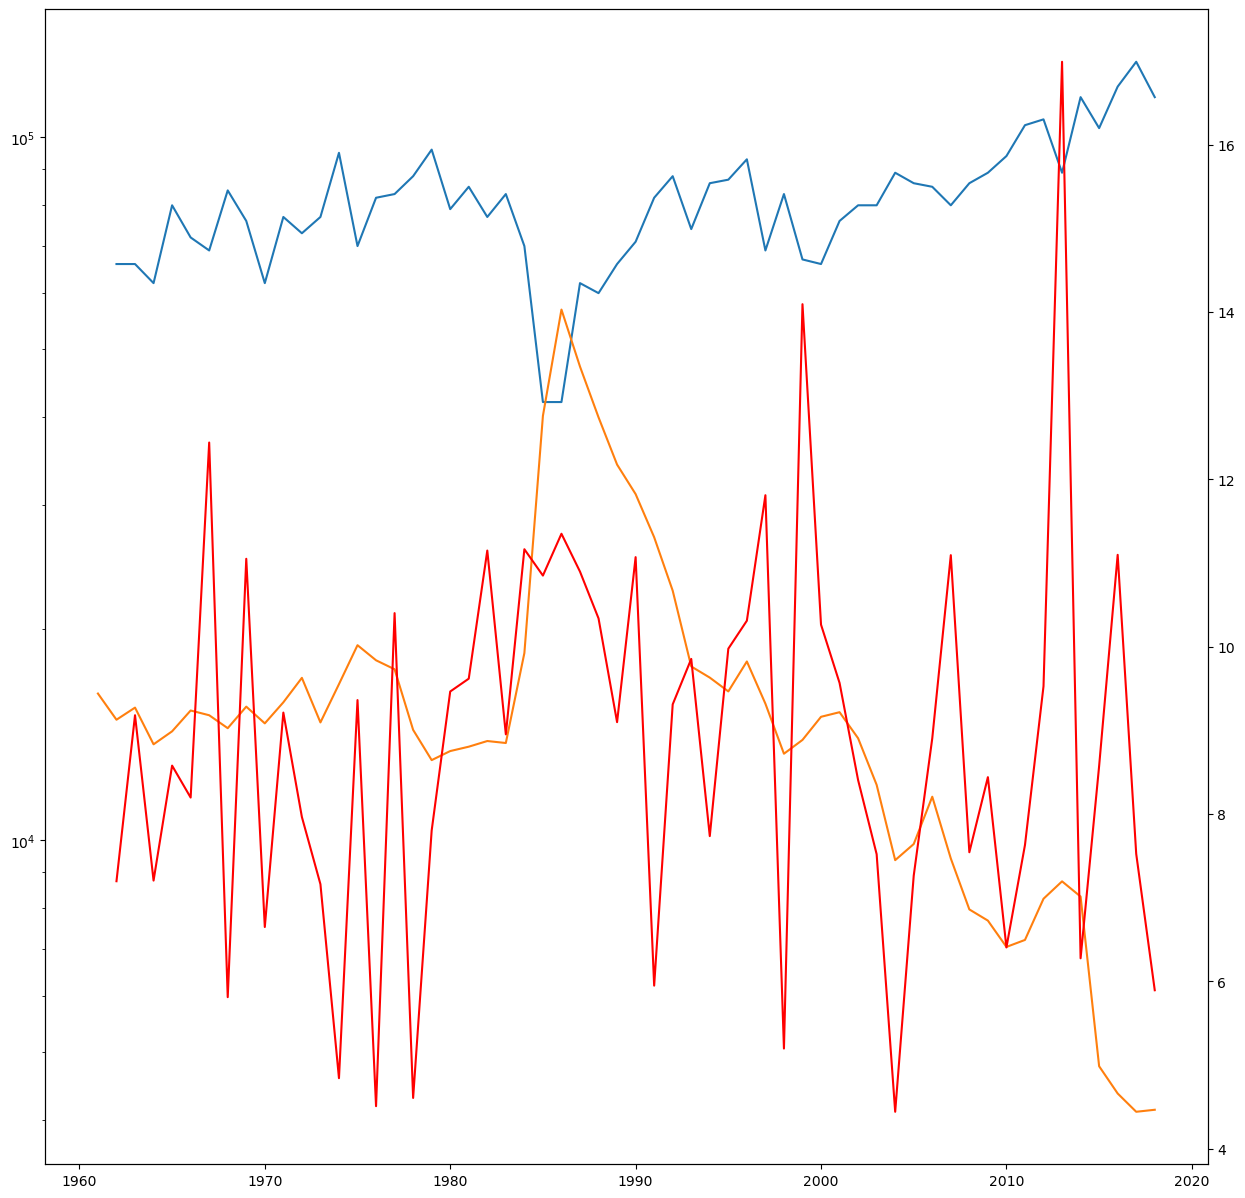

In [165]:
pump_flow_ppt = pd.concat([pumping['New_USGS'],
                           flow_wy['ac-ft/wy'],flow_cy['ac-ft/yr'] ,ppt_wy.sort_index()],axis=1).dropna()
pump_flow_ppt['New_USGS'].shift(2).plot()
pump_flow_ppt['ac-ft/yr'].shift(1).plot()
plt.yscale('log')
plt.twinx()
pump_flow_ppt['Precipitation'].shift(2).plot(color='red')


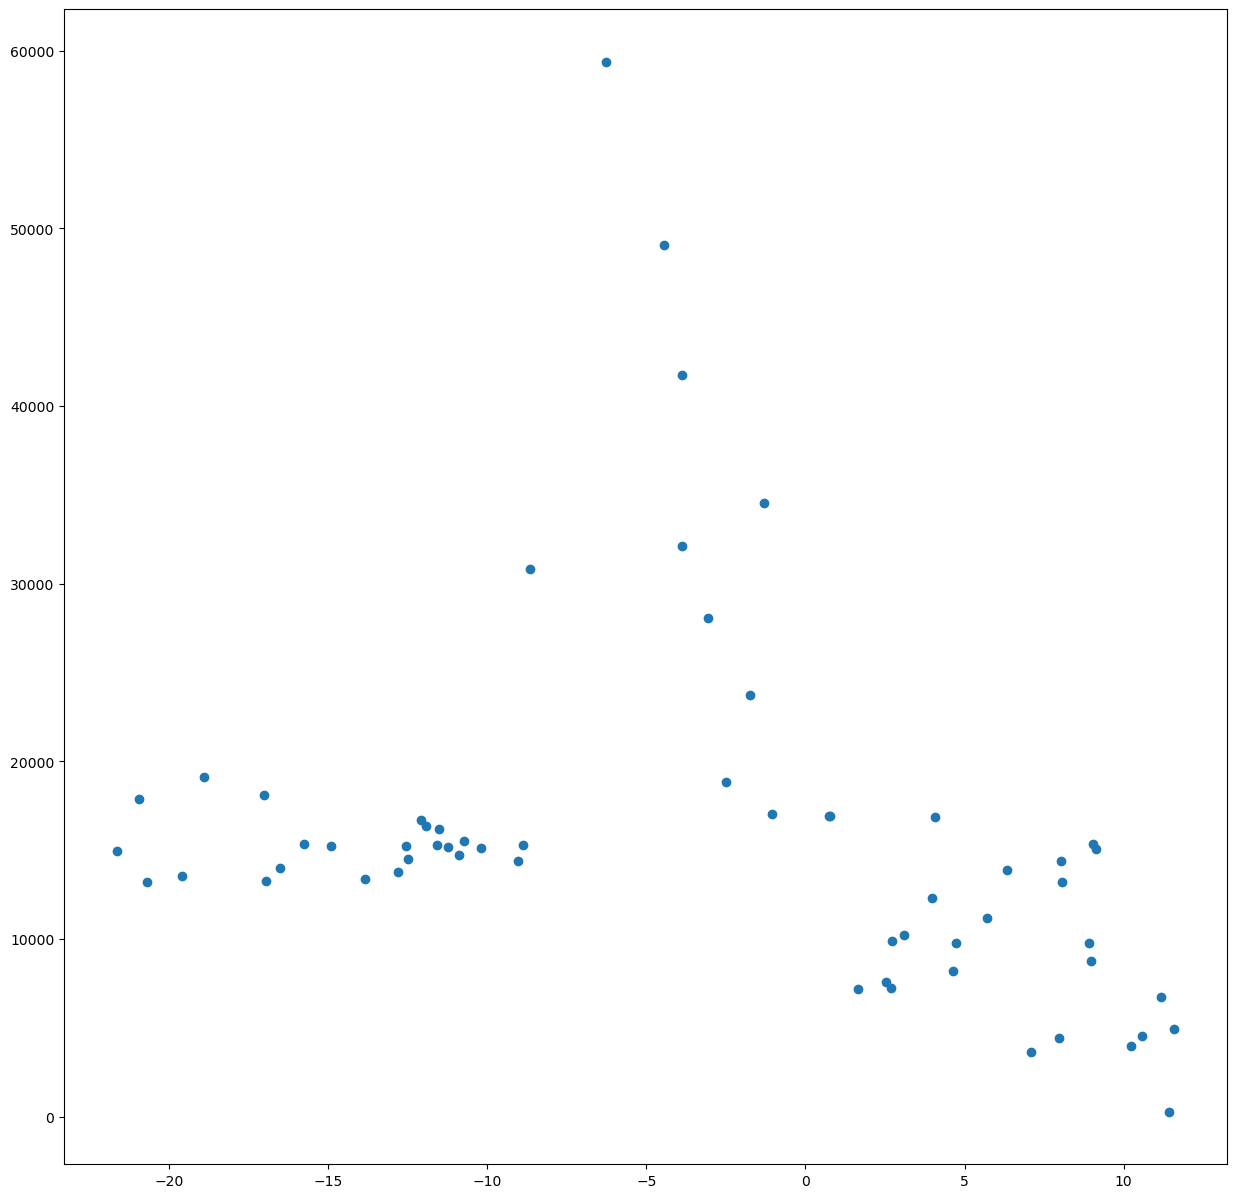

In [51]:
plt.scatter(pump_flow_ppt['cdm'],pump_flow_ppt['ac-ft/wy'])

In [52]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [103]:
ppt_flw_mo

,Flow,wateryear,Date,FILLMORE
1959-06-01,23.0,1959.0,1959-06-30,2.1
1959-07-01,23.0,1959.0,1959-07-30,5.3
1959-08-01,22.0,1959.0,1959-08-30,23.0
1959-09-01,20.0,1959.0,1959-09-30,31.3
1959-10-01,21.0,1960.0,1959-10-30,13.3
...,...,...,...,...
2018-07-01,5.7,2018.0,2018-07-14,14.8
2018-08-01,4.6,2018.0,2018-08-22,47.7
2018-09-01,2.8,2018.0,2018-09-20,0.0
2018-10-01,2.2,2019.0,2018-10-09,117.6


In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

https://www.datainsightonline.com/post/cross-correlation-with-two-time-series-in-python

C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311\Lib\site-packages\seaborn\relational.py:414: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



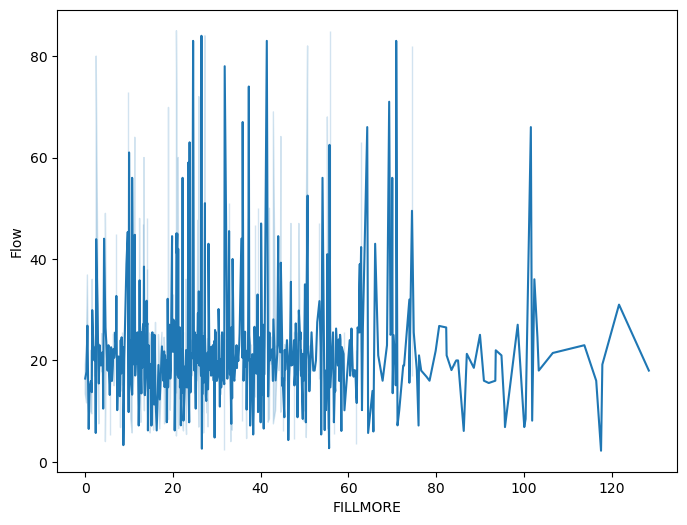

In [105]:

df = ppt_flw_mo

#df["week"] = pd.to_datetime(df["week"], format ="%d/%m/%Y").dt.date
#df["reg_ielts"] = pd.Series(np.random.randint(100, 220, size = len(df)))
#df.head()

fig = plt.figure(figsize = (8, 6))
sns.lineplot(data = df, x = 'FILLMORE', y ='Flow')
sns.lineplot(data = df, y ='Flow')
#plt.title('Search vs Registeration of IELTS', weight='bold', fontsize = 15)
#plt.ylabel('IELTS Search and Registration Count', weight='bold', fontsize = 12)
#lt.xlabel('Week', weight='bold', fontsize = 12)
plt.show()

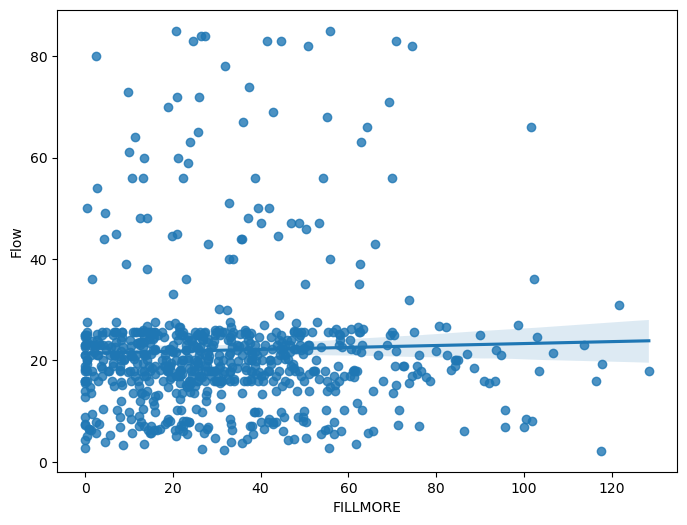

In [106]:
fig = plt.figure(figsize = (8, 6))
sns.regplot(data = df, x = 'FILLMORE', y ='Flow')
#plt.title('Search vs Registeration of IELTS ', weight='bold', fontsize = 15)
#plt.ylabel('Registeration Count', weight='bold', fontsize = 12)
#plt.xlabel('Search Count ', weight='bold', fontsize = 12)
plt.show()

In [108]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    result = pd.Series(dftest[0:4], index=['Test Statistic','P-value','Lags Used','No of Observations'])
    for key,value in dftest[4].items():
        result['Critical Value (%s)'%key] = value
    return result
    
    adf_table = df.drop('week', axis = 1)
    adf_table.apply(adf_test, axis = 0)
                                          

In [110]:
                                       
from scipy import signal
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c
    
ccf_ielts = ccf_values(df['FILLMORE'], df['Flow'])
ccf_ielts
                                           

array([ 2.47214565e-03,  4.70955586e-03,  5.43111905e-03, ...,
        2.09676161e-04,  3.36017131e-04, -3.33623491e-06])

In [130]:
df['Flow']

1959-06-01    23.0
1959-07-01    23.0
1959-08-01    22.0
1959-09-01    20.0
1959-10-01    21.0
              ... 
2018-07-01     5.7
2018-08-01     4.6
2018-09-01     2.8
2018-10-01     2.2
2018-11-01     2.4
Freq: MS, Name: Flow, Length: 714, dtype: float64

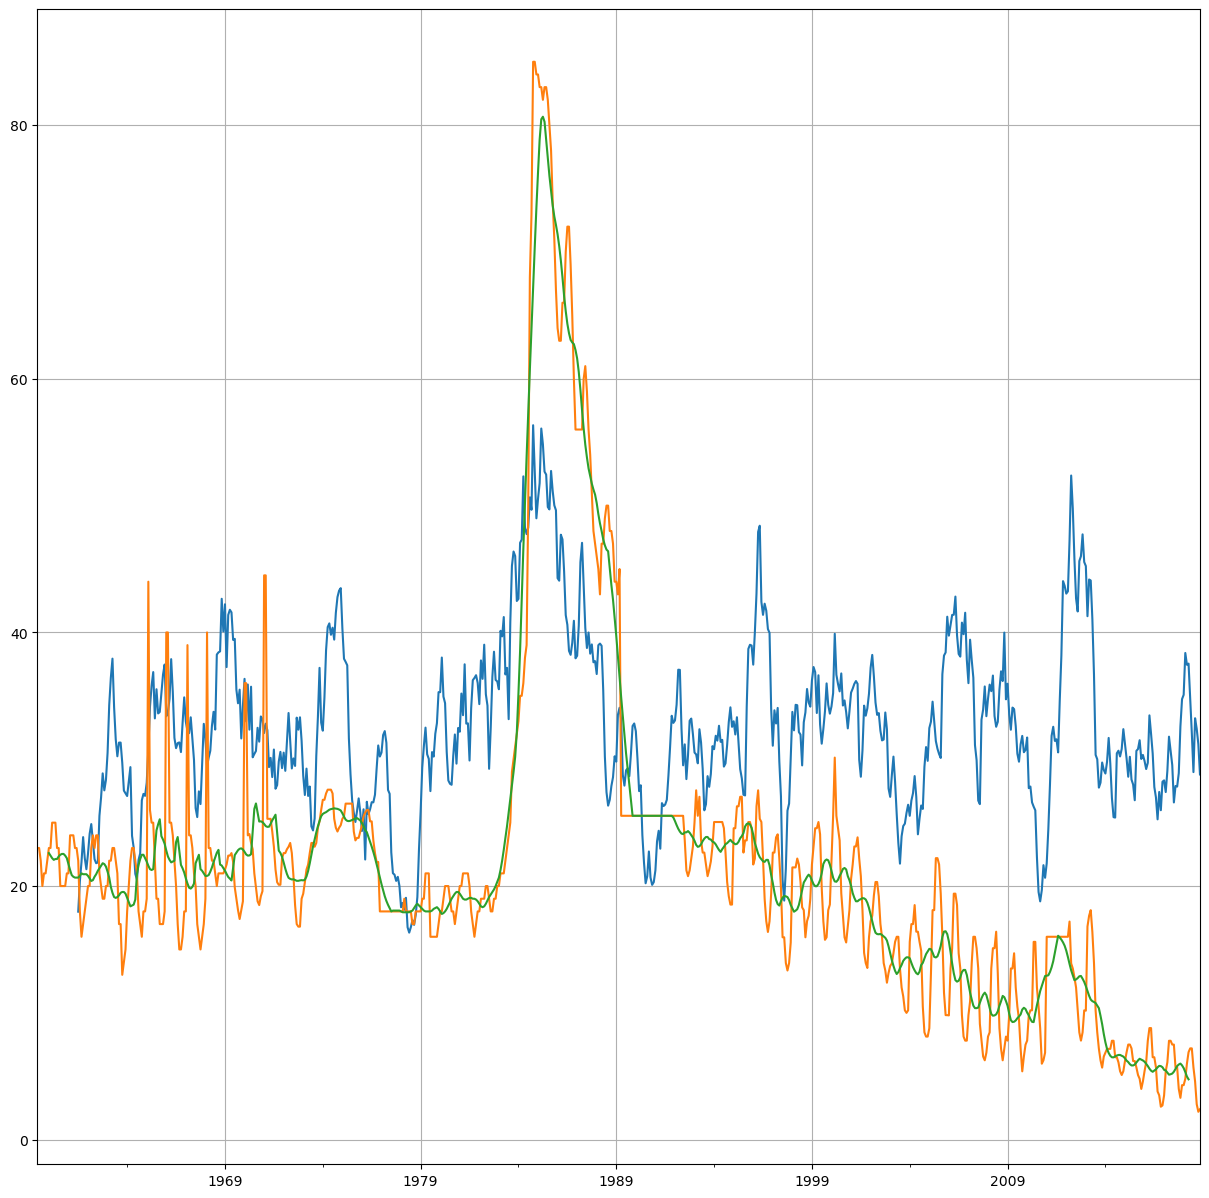

In [136]:
df['FILLMORE'].rolling(15,center=True).mean().shift(18).plot()
df['Flow'].plot()
df['Flow'].rolling(15,center=True).mean().plot()
plt.grid()

12-18 month lag between peak precip an peak springflow. Peak cross correlation at 14 months.

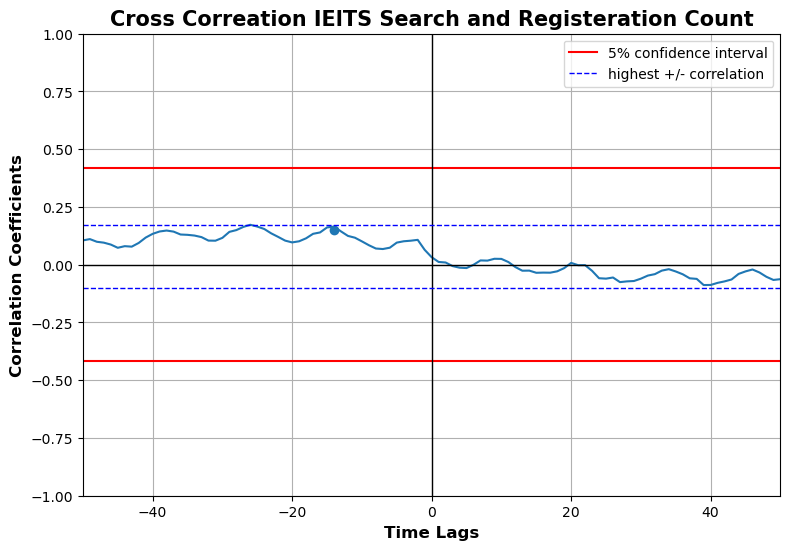

In [162]:
lags = signal.correlation_lags(len(df['FILLMORE']), len(df['Flow']))

def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, 
    linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, 
    linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correation IElTS Search and Registeration Count', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', 
    fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()
    
ccf_plot(lags, ccf_ielts)
plt.xlim(-50,50)
plt.grid()
plt.scatter(-14,0.15)